In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import requests 
from collections import Counter
import random
import decimal
import math
import random
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
dataInicial = '2017-11-20'
dataFinal = '2021-11-20'

In [3]:
##------------------------------Pegando os Dados-----------------------------------

url = "https://apitempo.inmet.gov.br/estacao/diaria/" + dataInicial + "/" + dataFinal + "/A307"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
resp = requests.get(url, headers=headers)
df = None
df_temp = None
if resp.status_code != 200:
    print (resp.raise_for_status())
else:
    df = pd.DataFrame(resp.json())
    #df = df[df["TEM_MAX"].astype('float') ]
    df_temp = df[df['TEMP_MAX'].notnull()]
    df_temp = df[df['UMID_MED'].notnull()]
    df_temp = df[df['DT_MEDICAO'].notnull()]
    
    df_temp = df[['TEMP_MAX', 'UMID_MED', 'DT_MEDICAO']]
    df_temp["id"] = df.index + 1 
    df_temp.dropna(inplace=True)

    df_umid = df[df['UMID_MED'].notnull()]
    df_umid = df[['UMID_MED']]
    df_umid["id"] = df.index + 1
    df_umid.dropna(inplace=True)

<ipython-input-3-ea3ea4aacd59>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["id"] = df.index + 1
<ipython-input-3-ea3ea4aacd59>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.dropna(inplace=True)
<ipython-input-3-ea3ea4aacd59>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_umid["id"] = df.index

In [4]:

df_training_temp = None
df_training_temp_anomalie_edit = None
desvioPadraoTempTraining = 0
desvioPadraoUmidTraining = 0

desvioPadraoTempTest = 0
desvioPadraoUmidTest = 0

desvioPadrao = 0

def valorFinalTemperatura(df_training_temp_anomalie_edit, treino, equacaoExponencial):
    valorFinalTemp = equacaoExponencial * extrairErro(df_training_temp_anomalie_edit, 'TEMP_MAX')
    return valorFinalTemp

def valorFinalUmidade(df_training_temp_anomalie_edit, treino, equacaoExponencial):
    valorFinalUmid = equacaoExponencial * extrairErro(df_training_temp_anomalie_edit, 'UMID_MED')
    return valorFinalUmid

def qtdRowsTemp():
    count_row_temp = df_temp.shape[0]
    return count_row_temp

def extrairErro(dataframe, coluna):
    train_size = int(dataframe.shape[0] * 1)
    train_Real, train_Pred = dataframe.to_numpy()[:,0], dataframe.to_numpy()[:,1]
    train_resid = [train_Real[i]-train_Pred[i] for i in range(len(dataframe))]
    desvioErro = np.std(train_resid)
    return desvioErro

def TransformarEmEstacionaria(df_training_temp):
    converterColunasToFloat(df_training_temp, "TEMP_MAX")
    converterColunasToFloat(df_training_temp, "UMID_MED")

    df_training_temp['UMID_MED'] = df_training_temp['UMID_MED'].diff()
    df_training_temp['TEMP_MAX'] = df_training_temp['TEMP_MAX'].diff()
    df_training_temp.dropna()
    return df_training_temp

def equacaoExponencial():
    numberX = decimal.Decimal(random.randrange(-50, 50))/100
    eq = math.exp((3 * abs(numberX))) + 3
    return float(eq)

def converterColunasToFloat(dataframe, coluna):
    dataframe[coluna] = dataframe[coluna].astype(float)
    dataframe[coluna].apply(lambda x: float(x))
    return dataframe


def autoReg(dataframe_anomalies_edit):
    ar_model = AutoReg(np.array(dataframe_anomalies_edit), trend='n', lags=1).fit()
    pred = ar_model.predict(start=0,end= dataframe_anomalies_edit.shape[0], dynamic=False)
    return pred

In [5]:
#------------------------------Tratando os Dados-----------------------------------

dfAnomaliasFinal =  pd.DataFrame()

def dataTraining(percentOutliers):
    
    qtd_training_temp = int(qtdRowsTemp()/3) * 2

    qtd_training_temp = qtdRowsTemp()

    df_training_temp = df_temp.sample(qtd_training_temp)

    df_training_temp = TransformarEmEstacionaria(df_training_temp) #Série Estacionária

    count_training_temp = int((df_training_temp.shape[0] * percentOutliers) / 100)    
    df_training_temp_anomalie_edit = df_training_temp.sample(n=count_training_temp)
    
    df_test_temp = pd.concat([df_temp, df_training_temp]).drop_duplicates(keep=False)

    df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_training_temp_anomalie_edit.dropna(inplace=True)

    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "TEMP_MAX")
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "UMID_MED")

    equacaoExpo = equacaoExponencial()
       
    temperaturas = autoReg(df_training_temp_anomalie_edit['TEMP_MAX']) #AutoRegressão
    umidades = autoReg(df_training_temp_anomalie_edit['UMID_MED']) #AutoRegressão
    
    df_ids = np.array(df_training_temp_anomalie_edit['id'])
    
    df_temp_real_pred = pd.DataFrame()
    colTemp = ['temp_real','temp_pred']
    df_temp_real_pred = pd.DataFrame(columns=colTemp)
    df_temp_real_pred['temp_real'] = df_training_temp_anomalie_edit['TEMP_MAX']
    df_temp_real_pred['temp_pred'] = temperaturas.tolist()

    df_umid_real_pred = pd.DataFrame()
    col_umid = ['umid_real','umid_pred']
    df_umid_real_pred = pd.DataFrame(columns=col_umid)
    df_umid_real_pred['umid_real'] = df_training_temp_anomalie_edit['UMID_MED']
    df_umid_real_pred['umid_pred'] = umidades.tolist()
    
    valorFinalTemp = valorFinalTemperatura(df_temp_real_pred, True, equacaoExpo)
    valorFinalUmid = valorFinalUmidade(df_umid_real_pred, True, equacaoExpo)
    
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "UMID_MED")
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "TEMP_MAX")

    dfAnomalias = pd.DataFrame()
    col = ['TEMP_MAX','UMID_MED', 'DT_MEDICAO', 'id']

    dfAnomalias = pd.DataFrame(columns=col)

    df_training_temp_anomalie_edit.sort_index(inplace=True)

    #Df Anomalias
    for index, row in df_training_temp_anomalie_edit.iterrows():
        temp = row['TEMP_MAX'] + (np.sign(row['TEMP_MAX']) * valorFinalTemp) #Cálculo outliers Temp
        umid = row['UMID_MED'] + (np.sign(row['UMID_MED']) * valorFinalUmid) #Cálculo outliers Umid
        x = np.array([[temp, umid, row['DT_MEDICAO'], row['id']]])
        df1=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED', 'DT_MEDICAO', 'id'])
        
        df1.set_index('id',inplace=True)

        dfAnomalias = pd.concat([df1, dfAnomalias])
   
    dfAnomalias = dfAnomalias.drop(columns='id')
        
    dfAnomalias.sort_index(inplace=True)    

    dfFinal = dfAnomalias
    

    #Inserindo as Anomalias junto das temps normais
    for index, row in df_training_temp.iterrows():
        x = np.array([[row['TEMP_MAX'], row['UMID_MED'], row['DT_MEDICAO'], row['id']]])
        df1=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED', 'DT_MEDICAO', 'id'])
        
        df1.set_index('id',inplace=True)
        
        dfFinal = pd.concat([df1, dfFinal])

    dfFinal.sort_index(inplace=True)    
    df_training_temp = dfFinal
    df_training_temp.dropna(inplace=True)

    dfAnomalias.sort_index(inplace=True)
    df_training_temp.sort_index(inplace=True)
    
    df_training_temp = converterColunasToFloat(df_training_temp, "TEMP_MAX")
    df_training_temp = converterColunasToFloat(df_training_temp, "UMID_MED")
    
    df_training_temp.dropna(inplace=True)
    df_training_temp.sort_index(inplace=True)
    
    return df_training_temp, dfAnomalias    

In [22]:
dfs = df_temp.sort_values(by="DT_MEDICAO")

df_temp['DT_MEDICAO'].astype('datetime64')
df_filterDate = (df_temp['DT_MEDICAO'] >= dataInicial) & (df_temp['DT_MEDICAO'] < "2019-11-20")
df_normal_values = df_temp.loc[df_filterDate]

In [24]:
df_temp = pd.concat([df_temp, df_normal_values]).drop_duplicates(keep=False).sort_values(by="DT_MEDICAO")

In [26]:
df_normal_values = TransformarEmEstacionaria(df_normal_values)
df_normal_values.dropna(inplace=True)

df_normal_values = converterColunasToFloat(df_normal_values, "TEMP_MAX")
df_normal_values = converterColunasToFloat(df_normal_values, "UMID_MED")

In [28]:
taxaContaminacao = 5
dfs = dataTraining(taxaContaminacao)
df_training_temp = dfs[0]
dfAnomalias = dfs[1]

dfAnomalias = dfAnomalias.sort_values(by="DT_MEDICAO")

df_training_temp = converterColunasToFloat(df_training_temp, "TEMP_MAX")
df_training_temp['TEMP_MAX'] = df_training_temp['TEMP_MAX'].abs()

df_training_temp = df_training_temp[df_training_temp.index.notnull()]

df_training_temp = df_training_temp.sort_values(by="DT_MEDICAO")

/home/anderson/Documentos/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/anderson/Documentos/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [29]:
print (dfAnomalias.shape)
print ("Anomalias:")
print (dfAnomalias)

(36, 3)
Anomalias:
                 TEMP_MAX             UMID_MED  DT_MEDICAO
805   -24.703078189444472    87.47229236782964  2020-02-02
827     22.60307818944448    87.57229236782965  2020-02-24
909    22.503078189444473    83.37229236782963  2020-05-16
925    -28.20307818944448    88.57229236782965  2020-06-01
935   -22.803078189444477    87.37229236782964  2020-06-11
939   -26.103078189444474    93.07229236782965  2020-06-15
961   -31.703078189444476   102.57229236782965  2020-07-07
962   -25.803078189444474    98.77229236782964  2020-07-08
1014   22.103078189444474   -86.07229236782965  2020-08-29
1016  -23.603078189444474   -82.87229236782964  2020-08-31
1024   23.403078189444475   -81.77229236782964  2020-09-08
1038   22.203078189444476    84.27229236782964  2020-09-22
1042   -21.80307818944447   -88.97229236782964  2020-09-26
1051   23.003078189444473   -93.67229236782964  2020-10-05
1067   22.803078189444477   -80.27229236782964  2020-10-21
1087    22.70307818944448    82.87229

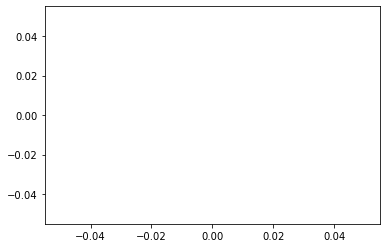

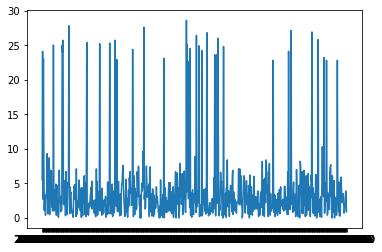

In [11]:
import matplotlib.pyplot as plt

#df_normal_values['TEMP_MAX'] = df_normal_values['TEMP_MAX'].abs()
series = pd.DataFrame(df_normal_values, columns = ['DT_MEDICAO', 'TEMP_MAX'])
series.reset_index(drop=True, inplace=True)

x = series['DT_MEDICAO']
y = series['TEMP_MAX']
plt.plot(x,y)
plt.show()


series = pd.DataFrame(df_training_temp, columns = ['DT_MEDICAO', 'TEMP_MAX'])
series.reset_index(drop=True, inplace=True)

x = series['DT_MEDICAO']
y = series['TEMP_MAX']
plt.plot(x,y)
plt.show()

In [154]:
# TDA magic
import gtda.time_series as time_series
import gtda.diagrams as diag
import gtda.homology as hl
import gtda.graphs as gr
from gtda.plotting import plot_diagram, plot_point_cloud
from gtda.pipeline import Pipeline
from plotting.plotting import plot_crash_detections, plot_crash_comparisons
from gtda.time_series import TakensEmbedding
import gtda.time_series as ts

In [128]:
data = np.array(df_training_temp)

df_training_temp.head()
df_training_temp.tail()
df_training_temp.shape

df_training_temp.dropna(inplace=True)

df_training_temp['DT_MEDICAO'] = df_training_temp['DT_MEDICAO'].astype('datetime64')

temps_resampled_df = pd.DataFrame(df_training_temp, columns = ['DT_MEDICAO', 'TEMP_MAX'])

#temps_resampled_df['DT_MEDICAO'] = temps_resampled_df['DT_MEDICAO'].astype('datetime64')

temps_resampled_df.set_index('DT_MEDICAO',inplace=True)
temps_values = temps_resampled_df["TEMP_MAX"].tolist()

embedding_series_with_anomalies = time_series.takens_embedding_optimal_parameters(temps_values, 
                                                            max_time_delay=20, 
                                                            max_dimension=20)


print (embedding_series_with_anomalies)

(19, 9)


In [129]:
from gtda.time_series import SingleTakensEmbedding
embedding_time_delay = embedding_series_with_anomalies[0]
embedding_dimension = embedding_series_with_anomalies[1]
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

temps_values_anomalie_embedded = embedder.fit_transform(temps_values)

In [156]:
sliding_window = ts.SlidingWindow(size=30, stride=5)
temps_values_anomalie_windows = sliding_window.fit_transform(temps_values_anomalie_embedded)

In [158]:
persistence = VietorisRipsPersistence(homology_dimensions=[0, 1, 2], n_jobs=-1)

In [159]:
#final_embbeded_anomalies = temps_values_anomalie_embedded[None, :, :]

persistences_diagrams_anomalies = persistence.fit_transform(temps_values_anomalie_windows)

plot_diagram(persistences_diagrams_anomalies[0])

In [160]:
persistences_diagrams_anomalies[0]

array([[ 0.        ,  1.70587218,  0.        ],
       [ 0.        ,  3.1622777 ,  0.        ],
       [ 0.        ,  3.28481364,  0.        ],
       [ 0.        ,  3.37490749,  0.        ],
       [ 0.        ,  3.48568511,  0.        ],
       [ 0.        ,  3.50285602,  0.        ],
       [ 0.        ,  3.74432898,  0.        ],
       [ 0.        ,  3.89743495,  0.        ],
       [ 0.        ,  3.90128183,  0.        ],
       [ 0.        ,  4.17851639,  0.        ],
       [ 0.        ,  4.23438311,  0.        ],
       [ 0.        ,  4.41021538,  0.        ],
       [ 0.        ,  4.44072056,  0.        ],
       [ 0.        ,  4.44971895,  0.        ],
       [ 0.        ,  4.65080643,  0.        ],
       [ 0.        ,  4.75920153,  0.        ],
       [ 0.        ,  4.81456137,  0.        ],
       [ 0.        ,  4.83321857,  0.        ],
       [ 0.        ,  4.90611839,  0.        ],
       [ 0.        ,  5.11077309,  0.        ],
       [ 0.        ,  5.28393793,  0.   

In [ ]:
########

In [ ]:
########

In [ ]:
###Data without anomalies##### 

In [136]:
df_normal_values.head()
df_normal_values.tail()
df_normal_values.shape

df_normal_values.dropna(inplace=True)

df_normal_values['DT_MEDICAO'] = df_normal_values['DT_MEDICAO'].astype('datetime64')
df_normal_resampled = pd.DataFrame(df_normal_values, columns = ['DT_MEDICAO', 'TEMP_MAX'])
df_normal_resampled.set_index('DT_MEDICAO',inplace=True)
normal_temps_values = df_normal_resampled["TEMP_MAX"].tolist()


embedding_series_without_anomalies = time_series.takens_embedding_optimal_parameters(normal_temps_values, 
                                                            max_time_delay=20, 
                                                            max_dimension=20)
print (embedding_series_without_anomalies)

(10, 6)


In [137]:
embedding_time_delay = embedding_series_without_anomalies[0]
embedding_dimension = embedding_series_without_anomalies[1]
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

normal_values_embedded = embedder.fit_transform(normal_temps_values)

In [143]:
plot_point_cloud(normal_values_embedded)

In [151]:
final_embbeded_normal_values = normal_values_embedded[None, :, :]

persistences_diagrams_normal_values = persistence.fit_transform(final_embbeded_normal_values)

plot_diagram(persistences_diagrams_normal_values[0])